# Advanced Applied Machine Learning - MovieLens Recommender System

Samih Amer

In [3]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 72
import numpy as np
import pandas as pd, re
import re
from collections import defaultdict
from numpy.linalg import norm
from scipy.spatial.distance import cosine 
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import gzip, io
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score

### Loading Dataset 

In [5]:
df_movies = pd.read_csv(r'/Users/samihamer/Desktop/Advanced Applied AI Summer 2025/movielens/movielens_movie.csv')
df_ratings = pd.read_csv(r'/Users/samihamer/Desktop/Advanced Applied AI Summer 2025/movielens/movielens_rating.csv')
df_tag = pd.read_csv(r'/Users/samihamer/Desktop/Advanced Applied AI Summer 2025/movielens/movielens_tag.csv')

df_genome_tags = pd.read_csv(r'/Users/samihamer/Desktop/Advanced Applied AI Summer 2025/movielens/movielens_genome_tags.csv')
df_genome_scores =  pd.read_csv(r'/Users/samihamer/Desktop/Advanced Applied AI Summer 2025/movielens/movielens_genome_scores.csv')

### Dataset Analysis and Visualization

In [7]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [9]:
df_tag.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


In [10]:
df_genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [11]:
df_genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [12]:
print(f"Number of unique movies= {len(df_movies)}")
print(f"Number of unique users= {len(df_ratings.userId.unique())}")

print(f"Number of unique rated movies= {len(df_ratings.movieId.unique())} (not all movies are rated by users)")

# MovieLens rating system
print(f"Number of tags= {len(df_genome_tags)}")
print(f"Number of tagger users= {len(df_tag.userId.unique())} (who created/assigned tags)")
print(f"Number of created unrefined tags= {len(df_tag.tag.unique())} (created tags, not-refined tags)")

Genres = defaultdict(int)
for genre in df_movies.genres:
    if 'no' not in genre:
        m = re.findall(r"([A-Za-z-]+)(?=\||$)", genre)
        if m:
            for gen in m:
                Genres[gen] += 1

print(f"Number of genres= {len(Genres.keys())}")

Number of unique movies= 27278
Number of unique users= 138493
Number of unique rated movies= 26744 (not all movies are rated by users)
Number of tags= 1128
Number of tagger users= 7801 (who created/assigned tags)
Number of created unrefined tags= 38644 (created tags, not-refined tags)
Number of genres= 19


## Problem 1: Build a Genome Vector, Score, and list the top Batman movies using similarity metrics

#### Define function to find all Batman-related movies in the dataset

In [15]:
def find_batman_movies(df_movies):
    batman_movies = df_movies[df_movies['title'].str.contains('Batman', case=False, na=False)]
    return batman_movies

In [16]:
batman_movies = find_batman_movies(df_movies)

In [17]:
print(f"Found {len(batman_movies)} Batman movies:")
print(batman_movies[['movieId', 'title']].to_string(index=False))

Found 25 Batman movies:
 movieId                                                     title
     153                                     Batman Forever (1995)
     592                                             Batman (1989)
    1377                                     Batman Returns (1992)
    1562                                     Batman & Robin (1997)
    3213                       Batman: Mask of the Phantasm (1993)
   26152                                             Batman (1966)
   27064                       Batman & Mr. Freeze: Subzero (1998)
   27155                         Batman/Superman Movie, The (1998)
   27311                 Batman Beyond: Return of the Joker (2000)
   33794                                      Batman Begins (2005)
   60979                              Batman: Gotham Knight (2008)
   79274                         Batman: Under the Red Hood (2010)
   80469                        Superman/Batman: Apocalypse (2010)
   90603                              

### Building genome matrix

Build a matrix where each row is a movie's genome vector

In [19]:
def build_genome_matrix(df_genome_scores):
    genome_matrix = df_genome_scores.pivot(index = 'movieId', columns = 'tagId', values = 'relevance')
    genome_matrix = genome_matrix.fillna(0)
    return genome_matrix

In [20]:
genome_matrix = build_genome_matrix(df_genome_scores)
print(f"Genome matrix shape: {genome_matrix.shape}")
print(f"Number of movies with genome data: {len(genome_matrix)}")
print(f"Number of genome tages: {genome_matrix.shape[1]}")

Genome matrix shape: (10381, 1128)
Number of movies with genome data: 10381
Number of genome tages: 1128


### Building a Batman Genome Vector 

We must create a single representative genome vector for the Batman Movies

In [22]:
def create_batman_genome_vector(batman_movie_ids, genome_matrix, method = 'mean'):
    batman_vectors = genome_matrix.loc[genome_matrix.index.isin(batman_movie_ids)]

    if batman_vectors.empty:
        print("No Batman movies found in genome data")
        return None, None

    print(f"Found {len(batman_vectors)} Batman movies in genome data:")
    for movie_id in batman_vectors.index:
        movie_title = df_movies[df_movies['movieId'] == movie_id]['title'].iloc[0]
        print(f" - {movie_title}")

    if method == 'mean':
        batman_genome = batman_vectors.mean(axis = 0)
    elif method == 'median':
        batman_genome = batman_vectors.median(axis = 0)
    elif mathod == 'max':
        batman_genome = batman_vectors.max(axis = 0)

    return batman_genome, batman_vectors

In [23]:
batman_movie_ids = batman_movies['movieId'].tolist()
batman_genome, batman_vectors = create_batman_genome_vector(batman_movie_ids, genome_matrix)

Found 19 Batman movies in genome data:
 - Batman Forever (1995)
 - Batman (1989)
 - Batman Returns (1992)
 - Batman & Robin (1997)
 - Batman: Mask of the Phantasm (1993)
 - Batman (1966)
 - Batman & Mr. Freeze: Subzero (1998)
 - Batman/Superman Movie, The (1998)
 - Batman Beyond: Return of the Joker (2000)
 - Batman Begins (2005)
 - Batman: Gotham Knight (2008)
 - Batman: Under the Red Hood (2010)
 - Superman/Batman: Apocalypse (2010)
 - Batman: Year One (2011)
 - Superman/Batman: Public Enemies (2009)
 - Batman: The Dark Knight Returns, Part 1 (2012)
 - Batman: The Dark Knight Returns, Part 2 (2013)
 - Son of Batman (2014)
 - Batman: Assault on Arkham (2014)


### Analyze Batman Genome Characteristics 

Get the most characteristic tags for Batman Movies

In [26]:
def get_top_batman_tags(batman_genome, df_genome_tags, top_n = 20):
    tag_scores = batman_genome.sort_values(ascending = False)
    top_tag_ids = tag_scores.head(top_n).index

    results = []
    for tag_id in top_tag_ids:
        tag_name = df_genome_tags[df_genome_tags['tagId'] == tag_id]['tag'].iloc[0]
        score = tag_scores[tag_id]
        results.append({'tag_id':tag_id, 'tag': tag_name, 'relevance':score})

    return pd.DataFrame(results)

In [27]:
batman_tags = get_top_batman_tags(batman_genome, df_genome_tags)
print("Top 20 genome tags for Batman movies:")
print(batman_tags.to_string(index = False))

Top 20 genome tags for Batman movies:
 tag_id              tag  relevance
    117           batman   0.982921
    987       super hero   0.927842
    989        superhero   0.919316
   1082        vigilante   0.915355
    990      superheroes   0.899132
    988       super-hero   0.892487
    288        dark hero   0.855421
    232       comic book   0.830539
     19           action   0.825303
    406        franchise   0.821776
    290        dc comics   0.811868
    742         original   0.805092
     49        alter ego   0.803408
    234           comics   0.769592
   1070        vengeance   0.762671
    389     fight scenes   0.717421
    108 based on a comic   0.710079
    971            story   0.686579
    777            pg-13   0.680987
   1083      vigilantism   0.670066


### Calculate similarity between Batman genome and all other movies

In [29]:
def calculate_similarities(batman_genome, genome_matrix, metric='cosine'):
    similarities = []
    
    for movie_id in genome_matrix.index:
        movie_vector = genome_matrix.loc[movie_id]
        
        if metric == 'cosine':
            similarity = 1 - cosine(batman_genome, movie_vector)
        elif metric == 'pearson':
            similarity, _ = pearsonr(batman_genome, movie_vector)
            if np.isnan(similarity):
                similarity = 0
        elif metric == 'euclidean':
            distance = np.linalg.norm(batman_genome - movie_vector)
            similarity = 1 / (1 + distance)
        
        similarities.append({'movieId': movie_id, 'similarity': similarity})
    
    return pd.DataFrame(similarities)

In [30]:
cosine_similarities = calculate_similarities(batman_genome, genome_matrix, 'cosine')

### Get top N most similar movies to Batman

In [32]:
def get_top_similar_movies(similarities_df, df_movies, top_n = 20, exclude_batman = True):
    top_movies = similarities_df.sort_values('similarity', ascending = False)
    top_movies = top_movies.merge(df_movies, on = 'movieId', how = 'left')

    if exclude_batman:
        top_movies = top_movies[~top_movies['title'].str.contains('Batman', case = False, na=False)]

    return top_movies.head(top_n)

In [33]:
top_similar_cosine = get_top_similar_movies(cosine_similarities, df_movies, top_n = 20)

print("Top 20 movies most similar to Batman using cosine similarity:")
for i, (_,movie) in enumerate(top_similar_cosine.iterrows(), 1):
    print(f"{i:2d}. {movie['title']:<60} | Score: {movie['similarity']:.4f} | Genres: {movie['genres']}")

Top 20 movies most similar to Batman using cosine similarity:
 1. Justice League: The Flashpoint Paradox (2013)                | Score: 0.9312 | Genres: Action|Adventure|Animation|Fantasy|Sci-Fi
 2. Justice League: Doom (2012)                                  | Score: 0.9141 | Genres: Action|Animation|Fantasy
 3. Justice League: Crisis on Two Earths (2010)                  | Score: 0.9108 | Genres: Action|Animation|Sci-Fi
 4. Justice League: The New Frontier (2008)                      | Score: 0.9082 | Genres: Action|Adventure|Animation|Fantasy|Sci-Fi
 5. Dark Knight, The (2008)                                      | Score: 0.9073 | Genres: Action|Crime|Drama|IMAX
 6. Dark Knight Rises, The (2012)                                | Score: 0.8943 | Genres: Action|Adventure|Crime|IMAX
 7. Green Lantern: First Flight (2009)                           | Score: 0.8939 | Genres: Action|Adventure|Animation|Fantasy|Sci-Fi
 8. Justice League: War (2014)                                   | Score: 

#### Compare different similarity metrics

In [35]:
metrics = ['cosine', 'pearson', 'euclidean']
all_similarities = {}

for metric in metrics:
    print(f"\n=== {metric.upper()} SIMILARITY ===")
    similarities = calculate_similarities(batman_genome, genome_matrix, metric)
    top_movies = get_top_similar_movies(similarities, df_movies, top_n=10)
    all_similarities[metric] = similarities
    
    print(f"Top 10 movies similar to Batman:")
    for i, (_, movie) in enumerate(top_movies.iterrows(), 1):
        print(f"{i:2d}. {movie['title']:<50} | Score: {movie['similarity']:.4f}")


=== COSINE SIMILARITY ===
Top 10 movies similar to Batman:
 1. Justice League: The Flashpoint Paradox (2013)      | Score: 0.9312
 2. Justice League: Doom (2012)                        | Score: 0.9141
 3. Justice League: Crisis on Two Earths (2010)        | Score: 0.9108
 4. Justice League: The New Frontier (2008)            | Score: 0.9082
 5. Dark Knight, The (2008)                            | Score: 0.9073
 6. Dark Knight Rises, The (2012)                      | Score: 0.8943
 7. Green Lantern: First Flight (2009)                 | Score: 0.8939
 8. Justice League: War (2014)                         | Score: 0.8866
 9. Superman Unbound (2013)                            | Score: 0.8825
10. Planet Hulk (2010)                                 | Score: 0.8810

=== PEARSON SIMILARITY ===
Top 10 movies similar to Batman:
 1. Justice League: The Flashpoint Paradox (2013)      | Score: 0.8822
 2. Justice League: Doom (2012)                        | Score: 0.8626
 3. Justice League: Crisis 

#### Visualization of results

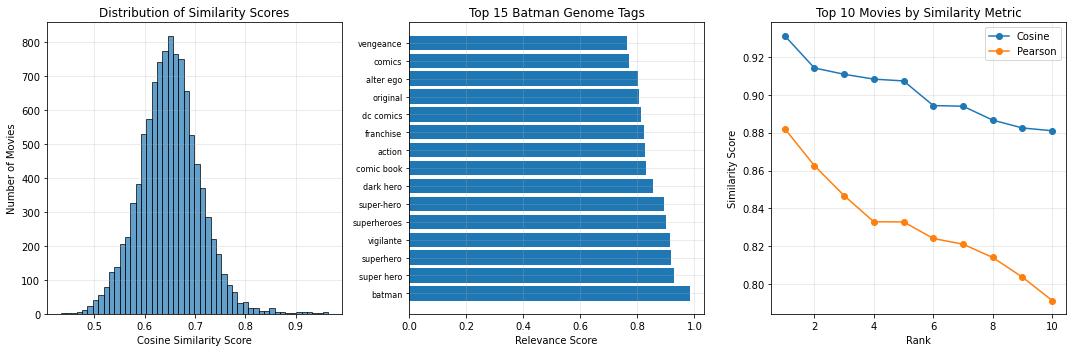

In [37]:
plt.figure(figsize = (15, 5))

# plot 1: Similarity score distribution
plt.subplot(1,3,1)
plt.hist(cosine_similarities['similarity'], bins = 50, alpha = 0.7, edgecolor = 'black')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Number of Movies')
plt.title('Distribution of Similarity Scores')
plt.grid(True, alpha=0.3)

# plot 2: Top Batman Tags
plt.subplot(1, 3, 2)
top_15_tags = batman_tags.head(15)
plt.barh(range(len(top_15_tags)), top_15_tags['relevance'])
plt.yticks(range(len(top_15_tags)), top_15_tags['tag'], fontsize=8)
plt.xlabel('Relevance Score')
plt.title('Top 15 Batman Genome Tags')
plt.grid(True, alpha=0.3)

# plot 3: Comparison of similarity metrics
plt.subplot(1, 3, 3)
for metric in ['cosine', 'pearson']:
    top_10 = get_top_similar_movies(all_similarities[metric], df_movies, top_n=10)
    plt.plot(range(1, 11), top_10['similarity'].values, marker='o', label=metric.capitalize())

plt.xlabel('Rank')
plt.ylabel('Similarity Score')
plt.title('Top 10 Movies by Similarity Metric')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Genre Analysis of similar movies

In [39]:
def analyze_genres(top_movies):
    genre_counts = {}
    for _, movie in top_movies.iterrows():
        if pd.notna(movie['genres']):
            genres = movie['genres'].split('|')
            for genre in genres:
                genre_counts[genre] = genre_counts.get(genre, 0) + 1
    
    return genre_counts

In [40]:
genre_analysis = analyze_genres(top_similar_cosine)
print("Genre distribution in top 20 Batman-similar movies:")
for genre, count in sorted(genre_analysis.items(), key=lambda x: x[1], reverse=True):
    print(f"{genre}: {count} movies")

Genre distribution in top 20 Batman-similar movies:
Action: 18 movies
Adventure: 13 movies
Sci-Fi: 12 movies
Animation: 11 movies
Fantasy: 6 movies
IMAX: 3 movies
Crime: 2 movies
Thriller: 2 movies
Drama: 1 movies
Comedy: 1 movies
Mystery: 1 movies


In [41]:
print("\nAnalyzing individual Batman movies:")
for movie_id in batman_vectors.index:
    movie_title = df_movies[df_movies['movieId'] == movie_id]['title'].iloc[0]
    movie_vector = batman_vectors.loc[movie_id]
    
    # Get top 5 tags for this Batman movie
    top_tags = movie_vector.nlargest(5)
    tag_names = []
    for tag_id in top_tags.index:
        tag_name = df_genome_tags[df_genome_tags['tagId'] == tag_id]['tag'].iloc[0]
        tag_names.append(f"{tag_name} ({top_tags[tag_id]:.3f})")
    
    print(f"\n{movie_title}:")
    print(f"  Top genome tags: {', '.join(tag_names)}")


Analyzing individual Batman movies:

Batman Forever (1995):
  Top genome tags: batman (0.993), super-hero (0.987), franchise (0.986), vigilante (0.968), super hero (0.959)

Batman (1989):
  Top genome tags: dark hero (0.998), super hero (0.993), vigilante (0.993), super-hero (0.992), batman (0.991)

Batman Returns (1992):
  Top genome tags: dark hero (0.996), batman (0.992), super-hero (0.989), vigilante (0.988), super hero (0.970)

Batman & Robin (1997):
  Top genome tags: batman (0.990), super-hero (0.990), franchise (0.988), dark hero (0.952), superhero (0.950)

Batman: Mask of the Phantasm (1993):
  Top genome tags: vigilante (0.998), batman (0.991), super-hero (0.985), super hero (0.970), superhero (0.951)

Batman (1966):
  Top genome tags: batman (0.984), super-hero (0.961), camp (0.959), franchise (0.936), superhero (0.932)

Batman & Mr. Freeze: Subzero (1998):
  Top genome tags: dark hero (0.998), batman (0.992), super hero (0.965), super-hero (0.958), superheroes (0.948)

Bat

## Problem 2: Find top-10 Batman-loving users and their second most loved movies

### First, Find Batman-loving users

We will find the users who gave high ratings to Batman movies

In [44]:
def find_batman_loving_users(df_ratings, batman_movie_ids, min_rating = 4.0):
    batman_ratings = df_ratings[df_ratings['movieId'].isin(batman_movie_ids)]
    high_batman_ratings = batman_ratings[batman_ratings['rating'] >= min_rating]

    user_stats = high_batman_ratings.groupby('userId').agg({'rating': ['count', 'mean', 'sum'], 'movieId': 'nunique'}).round(3)

    user_stats.columns = ['high_rating_count', 'avg_high_rating', 'total_rating_sum', 'unique_batman_movies']
    user_stats = user_stats.reset_index()

    user_stats['batman_love_score'] = (
        user_stats['avg_high_rating'] * 0.4 +
        user_stats['high_rating_count'] * 0.3 +
        user_stats['unique_batman_movies'] * 0.3
    )

    return user_stats.sort_values('batman_love_score', ascending=False), high_batman_ratings


In [45]:
batman_lovers, high_batman_ratings = find_batman_loving_users(df_ratings, batman_movie_ids)
top_10_batman_users = batman_lovers.head(10)
print("Top 10 Batman-loving users:")
print("="*60)
for i, (_, user) in enumerate(top_10_batman_users.iterrows(), 1):
    print(f"{i:2d}. User {user['userId']:>6} | Love Score: {user['batman_love_score']:.3f} | "
          f"High Ratings: {int(user['high_rating_count'])} | Avg: {user['avg_high_rating']:.2f}")


Top 10 Batman-loving users:
 1. User 32576.0 | Love Score: 12.700 | High Ratings: 18 | Avg: 4.75
 2. User 95573.0 | Love Score: 11.000 | High Ratings: 15 | Avg: 5.00
 3. User 37385.0 | Love Score: 10.827 | High Ratings: 15 | Avg: 4.57
 4. User 91238.0 | Love Score: 10.086 | High Ratings: 14 | Avg: 4.21
 5. User 104701.0 | Love Score: 10.000 | High Ratings: 14 | Avg: 4.00
 6. User 123352.0 | Love Score: 9.554 | High Ratings: 13 | Avg: 4.38
 7. User 115843.0 | Love Score: 8.983 | High Ratings: 12 | Avg: 4.46
 8. User 28625.0 | Love Score: 8.967 | High Ratings: 12 | Avg: 4.42
 9. User 131894.0 | Love Score: 8.582 | High Ratings: 11 | Avg: 4.96
10. User 46470.0 | Love Score: 8.473 | High Ratings: 11 | Avg: 4.68


### Find second most loved movies for these users using genome similarity

In [47]:
def find_second_most_loved_movies(top_users, df_ratings, df_movies, genome_matrix, batman_genome):
    results = []
    
    for _, user in top_users.iterrows():
        user_id = user['userId']
        
        # User's non-Batman high ratings (4.0+) with genome data
        user_ratings = df_ratings[df_ratings['userId'] == user_id]
        non_batman_ratings = user_ratings[
            (~user_ratings['movieId'].isin(batman_movie_ids)) &
            (user_ratings['rating'] >= 4.0) &
            (user_ratings['movieId'].isin(genome_matrix.index))
        ]
        
        if len(non_batman_ratings) == 0:
            results.append({
                'userId': user_id,
                'second_movie_title': 'No suitable movies found',
                'rating': None,
                'similarity_to_batman': None
            })
            continue
        
        # Calculate Batman similarity for each movie
        movie_similarities = []
        for _, rating_row in non_batman_ratings.iterrows():
            movie_id = rating_row['movieId']
            movie_vector = genome_matrix.loc[movie_id]
            similarity = 1 - cosine(batman_genome, movie_vector)
            
            movie_similarities.append({
                'movieId': movie_id,
                'rating': rating_row['rating'],
                'similarity_to_batman': similarity
            })
        
        # Sort by similarity to Batman (most similar = second most loved)
        movie_similarities.sort(key=lambda x: x['similarity_to_batman'], reverse=True)
        
        best_match = movie_similarities[0]
        movie_info = df_movies[df_movies['movieId'] == best_match['movieId']].iloc[0]
        
        results.append({
            'userId': user_id,
            'second_movie_id': best_match['movieId'],
            'second_movie_title': movie_info['title'],
            'second_movie_genres': movie_info['genres'],
            'rating': best_match['rating'],
            'similarity_to_batman': best_match['similarity_to_batman'],
            'total_options': len(movie_similarities)
        })
    
    return pd.DataFrame(results)

#### Analysis of results

In [49]:
second_loved_results = find_second_most_loved_movies(
    top_10_batman_users, df_ratings, df_movies, genome_matrix, batman_genome
)

print("\n" + "="*100)
print("SECOND MOST LOVED MOVIES (Most Batman-similar non-Batman movies):")
print("="*100)

for i, (_, result) in enumerate(second_loved_results.iterrows(), 1):
    if result['second_movie_title'] != 'No suitable movies found':
        print(f"{i:2d}. User {result['userId']:>6} | {result['second_movie_title']:<50}")
        print(f"     Rating: {result['rating']:.1f} | Batman Similarity: {result['similarity_to_batman']:.4f}")
        print(f"     Genres: {result['second_movie_genres']}")
        print(f"     (Selected from {result['total_options']} high-rated options)")
    else:
        print(f"{i:2d}. User {result['userId']:>6} | {result['second_movie_title']}")
    print()


SECOND MOST LOVED MOVIES (Most Batman-similar non-Batman movies):
 1. User 32576.0 | Justice League: The Flashpoint Paradox (2013)     
     Rating: 5.0 | Batman Similarity: 0.9312
     Genres: Action|Adventure|Animation|Fantasy|Sci-Fi
     (Selected from 90 high-rated options)

 2. User 95573.0 | Blade (1998)                                      
     Rating: 5.0 | Batman Similarity: 0.8543
     Genres: Action|Horror|Thriller
     (Selected from 20 high-rated options)

 3. User 37385.0 | Spider-Man (2002)                                 
     Rating: 5.0 | Batman Similarity: 0.8779
     Genres: Action|Adventure|Sci-Fi|Thriller
     (Selected from 28 high-rated options)

 4. User 91238.0 | Justice League: The Flashpoint Paradox (2013)     
     Rating: 4.5 | Batman Similarity: 0.9312
     Genres: Action|Adventure|Animation|Fantasy|Sci-Fi
     (Selected from 192 high-rated options)

 5. User 104701.0 | Spider-Man (2002)                                 
     Rating: 4.0 | Batman Similar

In [50]:
valid_second_movies = second_loved_results[second_loved_results['second_movie_title'] != 'No suitable movies found']

### Analysis of second loved movies as well as visualization of results


ANALYSIS SUMMARY:
  Users with valid second movies: 10/10
  Average Batman similarity: 0.9081
  Average rating: 4.60
  Most common genres: Action, Adventure, Sci-Fi, Animation, Fantasy


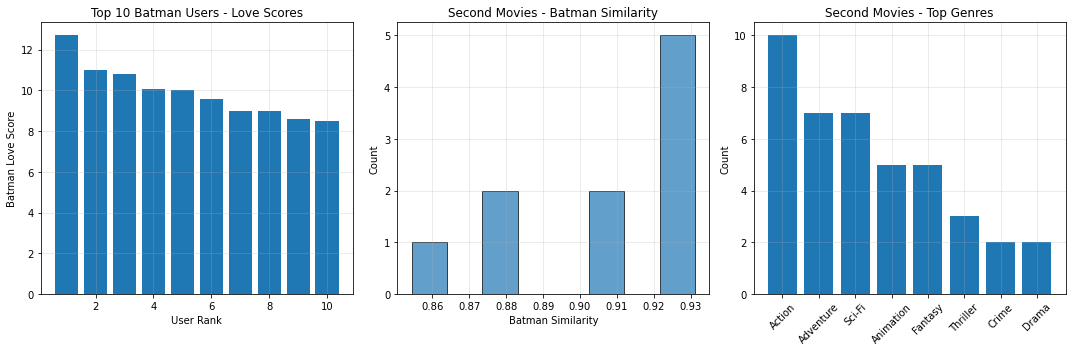

In [52]:
print(f"\nANALYSIS SUMMARY:")
print(f"  Users with valid second movies: {len(valid_second_movies)}/10")

if len(valid_second_movies) > 0:
    all_genres = []
    for _, result in valid_second_movies.iterrows():
        genres = result['second_movie_genres'].split('|')
        all_genres.extend(genres)
    
    genre_counts = pd.Series(all_genres).value_counts()
    print(f"  Average Batman similarity: {valid_second_movies['similarity_to_batman'].mean():.4f}")
    print(f"  Average rating: {valid_second_movies['rating'].mean():.2f}")
    print(f"  Most common genres: {', '.join(genre_counts.head(5).index.tolist())}")

plt.figure(figsize=(15, 5))

# Plot 1: Batman love scores
plt.subplot(1, 3, 1)
plt.bar(range(1, 11), top_10_batman_users['batman_love_score'])
plt.xlabel('User Rank')
plt.ylabel('Batman Love Score')
plt.title('Top 10 Batman Users - Love Scores')
plt.grid(True, alpha=0.3)

# Plot 2: Second movie similarities 
if len(valid_second_movies) > 0:
    plt.subplot(1, 3, 2)
    plt.hist(valid_second_movies['similarity_to_batman'], bins=8, alpha=0.7, edgecolor='black')
    plt.xlabel('Batman Similarity')
    plt.ylabel('Count')
    plt.title('Second Movies - Batman Similarity')
    plt.grid(True, alpha=0.3)

# Plot 3: Genre distribution
if len(valid_second_movies) > 0:
    plt.subplot(1, 3, 3)
    top_genres = genre_counts.head(8)
    plt.bar(range(len(top_genres)), top_genres.values)
    plt.xticks(range(len(top_genres)), top_genres.index, rotation=45)
    plt.ylabel('Count')
    plt.title('Second Movies - Top Genres')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [53]:
if len(valid_second_movies) > 0:
    print(f"\nKey insights:")
    print(f"  - Second movies have {valid_second_movies['similarity_to_batman'].mean():.1%} average similarity to Batman")
    print(f"  - Users rated their second movies {valid_second_movies['rating'].mean():.1f}/5.0 on average")
    print(f"  - Most common genre in second movies: {genre_counts.index[0]}")


Key insights:
  - Second movies have 90.8% average similarity to Batman
  - Users rated their second movies 4.6/5.0 on average
  - Most common genre in second movies: Action


## Probem 3: Find the best genre for Batman Movies

#### Extract and analyze Batman movie genres

In [56]:
def analyze_batman_genres(batman_movies, df_ratings):
    
    batman_genre_data = []
    
    for _, movie in batman_movies.iterrows():
        movie_id = movie['movieId']
        title = movie['title']
        genres = movie['genres']
        
        movie_ratings = df_ratings[df_ratings['movieId'] == movie_id]
        
        if len(movie_ratings) > 0:
            avg_rating = movie_ratings['rating'].mean()
            num_ratings = len(movie_ratings)
        else:
            avg_rating = 0
            num_ratings = 0
        
        if pd.notna(genres) and genres != "(no genres listed)":
            genre_list = genres.split('|')
            for genre in genre_list:
                batman_genre_data.append({
                    'movieId': movie_id,
                    'title': title,
                    'genre': genre.strip(),
                    'avg_rating': avg_rating,
                    'num_ratings': num_ratings
                })
    
    return pd.DataFrame(batman_genre_data)

In [57]:
batman_genre_df = analyze_batman_genres(batman_movies, df_ratings)

In [58]:
print("BATMAN MOVIE GENRES:")
print("="*40)
print(f"Batman movies analyzed: {len(batman_movies)}")
print(f"Batman movies with ratings: {len(batman_genre_df['movieId'].unique())}")
print(f"Unique genres: {len(batman_genre_df['genre'].unique())}")

print("\nGenre distribution in Batman movies:")
genre_counts = batman_genre_df['genre'].value_counts()
print(genre_counts.to_string())

BATMAN MOVIE GENRES:
Batman movies analyzed: 25
Batman movies with ratings: 25
Unique genres: 13

Genre distribution in Batman movies:
genre
Action         22
Animation      16
Crime          13
Adventure       8
Thriller        6
Sci-Fi          5
Fantasy         4
Children        4
Comedy          2
IMAX            1
Drama           1
Documentary     1
Horror          1


### Calculate comprehensive performance metrics for each genre

In [60]:
def calculate_genre_performance(batman_genre_df):
    
    genre_stats = batman_genre_df.groupby('genre').agg({
        'movieId': 'nunique',           # Number of movies
        'avg_rating': 'mean',           # Average rating
        'num_ratings': ['sum', 'mean']  # Total and average ratings per movie
    }).round(4)
    
    genre_stats.columns = ['num_movies', 'mean_avg_rating', 'total_ratings', 'avg_ratings_per_movie']
    genre_stats = genre_stats.reset_index()
    
    max_movies = genre_stats['num_movies'].max()
    max_ratings = genre_stats['total_ratings'].max()
    max_avg_rating = genre_stats['mean_avg_rating'].max()
    
    genre_stats['movie_presence_score'] = genre_stats['num_movies'] / max_movies
    genre_stats['popularity_score'] = genre_stats['total_ratings'] / max_ratings
    genre_stats['quality_score'] = genre_stats['mean_avg_rating'] / max_avg_rating
    
    genre_stats['best_genre_score'] = (
        genre_stats['quality_score'] * 0.4 +        # 40% rating quality
        genre_stats['popularity_score'] * 0.3 +     # 30% user engagement
        genre_stats['movie_presence_score'] * 0.3   # 30% genre prevalence
    )
    
    return genre_stats.sort_values('best_genre_score', ascending=False)

In [61]:
genre_performance = calculate_genre_performance(batman_genre_df)

In [62]:
print("\nGENRE PERFORMANCE RANKING:")
print("="*70)
print(f"{'Rank':<4} {'Genre':<12} {'Movies':<7} {'Avg Rating':<10} {'Total Ratings':<12} {'Score':<8}")
print("-" * 70)

for i, (_, genre) in enumerate(genre_performance.iterrows(), 1):
    print(f"{i:<4} {genre['genre']:<12} {int(genre['num_movies']):<7} "
          f"{genre['mean_avg_rating']:<10.3f} {int(genre['total_ratings']):<12} "
          f"{genre['best_genre_score']:<8.3f}")


GENRE PERFORMANCE RANKING:
Rank Genre        Movies  Avg Rating Total Ratings Score   
----------------------------------------------------------------------
1    Action       22      3.361      122726       0.939   
2    Crime        13      3.399      111539       0.792   
3    Animation    16      3.495      4171         0.580   
4    Thriller     6       3.185      55614        0.539   
5    Adventure    8       3.034      42989        0.520   
6    IMAX         1       3.971      18686        0.459   
7    Comedy       2       3.043      33650        0.416   
8    Sci-Fi       5       3.355      810          0.408   
9    Children     4       3.353      1910         0.397   
10   Documentary  1       3.778      9            0.394   
11   Fantasy      4       3.063      9337         0.386   
12   Horror       1       3.250      4            0.341   
13   Drama        1       3.000      16           0.316   


#### Plot visualization of analysis

Text(0.5, 1.0, 'Quality vs Popularity')

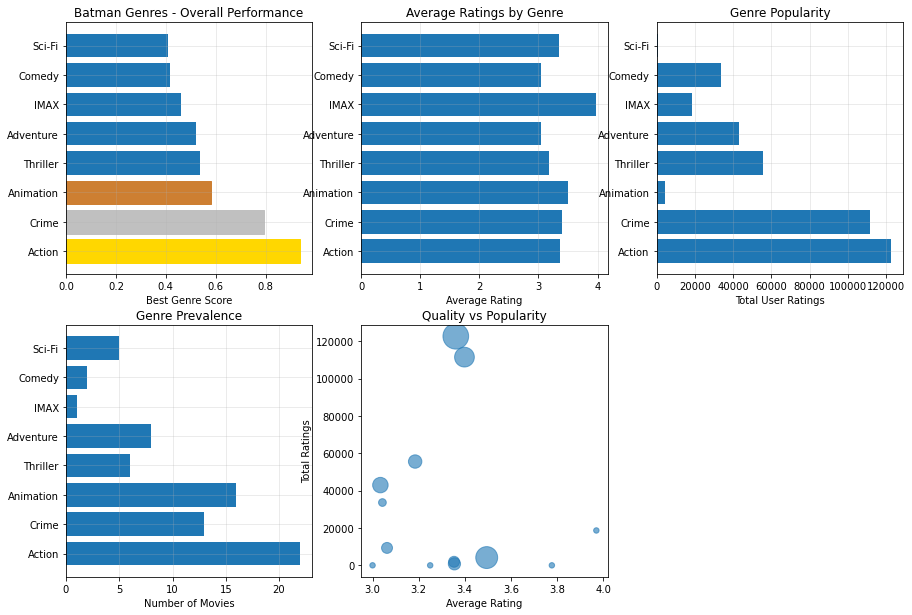

In [64]:
plt.figure(figsize=(15, 10))

# Plot 1: Best Genre Scores
plt.subplot(2, 3, 1)
top_8 = genre_performance.head(8)
bars = plt.barh(range(len(top_8)), top_8['best_genre_score'])
plt.yticks(range(len(top_8)), top_8['genre'])
plt.xlabel('Best Genre Score')
plt.title('Batman Genres - Overall Performance')
plt.grid(True, alpha=0.3)

bars[0].set_color('gold')
bars[1].set_color('silver')
bars[2].set_color('#CD7F32') 

# Plot 2: Average Ratings
plt.subplot(2, 3, 2)
plt.barh(range(len(top_8)), top_8['mean_avg_rating'])
plt.yticks(range(len(top_8)), top_8['genre'])
plt.xlabel('Average Rating')
plt.title('Average Ratings by Genre')
plt.grid(True, alpha=0.3)

# Plot 3: Popularity (Total Ratings)
plt.subplot(2, 3, 3)
plt.barh(range(len(top_8)), top_8['total_ratings'])
plt.yticks(range(len(top_8)), top_8['genre'])
plt.xlabel('Total User Ratings')
plt.title('Genre Popularity')
plt.grid(True, alpha=0.3)

# Plot 4: Number of Movies per Genre
plt.subplot(2, 3, 4)
plt.barh(range(len(top_8)), top_8['num_movies'])
plt.yticks(range(len(top_8)), top_8['genre'])
plt.xlabel('Number of Movies')
plt.title('Genre Prevalence')
plt.grid(True, alpha=0.3)

# Plot 5: Quality vs Popularity
plt.subplot(2, 3, 5)
plt.scatter(genre_performance['mean_avg_rating'], genre_performance['total_ratings'], 
           s=genre_performance['num_movies']*30, alpha=0.6)
plt.xlabel('Average Rating')
plt.ylabel('Total Ratings')
plt.title('Quality vs Popularity')

In [65]:
best_genre = genre_performance.iloc[0]

In [66]:
print("BEST GENRE FOR BATMAN MOVIES")

print(f"WINNER: {best_genre['genre'].upper()}")
print(f"  • Best Genre Score: {best_genre['best_genre_score']:.3f}/1.000")
print(f"  • Average Rating: {best_genre['mean_avg_rating']:.3f}/5.0")
print(f"  • Batman Movies: {int(best_genre['num_movies'])}")
print(f"  • Total User Ratings: {int(best_genre['total_ratings']):,}")
print(f"  • Average Ratings per Movie: {best_genre['avg_ratings_per_movie']:.1f}")

print(f"\nFULL RANKING:")
for i, (_, genre) in enumerate(genre_performance.head(10).iterrows(), 1):
    print(f"{genre['genre']:<12} (Score: {genre['best_genre_score']:.3f})")

print(f"\nKEY INSIGHTS:")
print(f"{best_genre['genre']} is the optimal genre for Batman movies")
print(f"This genre balances quality (rating), popularity (user engagement), and presence")
print(f"Movies in this genre receive {best_genre['mean_avg_rating']:.2f}/5.0 average rating")
print(f"Appears in {int(best_genre['num_movies'])}/{len(batman_movies)} Batman movies")

BEST GENRE FOR BATMAN MOVIES
WINNER: ACTION
  • Best Genre Score: 0.939/1.000
  • Average Rating: 3.361/5.0
  • Batman Movies: 22
  • Total User Ratings: 122,726
  • Average Ratings per Movie: 5578.5

FULL RANKING:
Action       (Score: 0.939)
Crime        (Score: 0.792)
Animation    (Score: 0.580)
Thriller     (Score: 0.539)
Adventure    (Score: 0.520)
IMAX         (Score: 0.459)
Comedy       (Score: 0.416)
Sci-Fi       (Score: 0.408)
Children     (Score: 0.397)
Documentary  (Score: 0.394)

KEY INSIGHTS:
Action is the optimal genre for Batman movies
This genre balances quality (rating), popularity (user engagement), and presence
Movies in this genre receive 3.36/5.0 average rating
Appears in 22/25 Batman movies


## Problem 4: Extract Features, X matrix: Utilize the user tags (df_tag DataFrame) to build item vectors for clustering. The same approach can be used in the module with the GloVe world embeddings

Build X matrix from user tags

In [69]:
def build_tag_vectors(df_tag, df_movies, min_tag_freq=2):

    df_tag = df_tag.assign(tag=df_tag['tag'].fillna('').astype(str))

    # concatenate tags per movie
    movie_tags = (df_tag
                  .groupby('movieId')['tag']
                  .apply(lambda tags: ' '.join(tags.str.lower()))
                  .reset_index()
                 )

    # merge titles
    movie_vectors = movie_tags.merge(df_movies[['movieId', 'title']],
                                     on='movieId', how='left')

    # TF-IDF
    vectorizer = TfidfVectorizer(
        max_features=500,
        min_df=min_tag_freq,
        stop_words='english',
        ngram_range=(1, 2)
    )
    X_matrix = vectorizer.fit_transform(movie_vectors['tag'])  # ← feature matrix

    return X_matrix, movie_vectors, vectorizer

In [70]:
X_matrix, movie_tag_data, tag_vectorizer = build_tag_vectors(df_tag, df_movies)

#### Load GloVe lookup table

In [72]:
glove_path = "glove.6B.50d.txt.gz"  

In [73]:
def load_glove(path):
    word2vec = {}
    with gzip.open(path, "rt", encoding="utf-8") as f:
        for line in f:
            parts = line.rstrip().split()
            word, vec = parts[0], np.asarray(parts[1:], dtype="float32")
            word2vec[word] = vec
    return word2vec

In [74]:
glove = load_glove(glove_path)
glove_dim = next(iter(glove.values())).shape[0]
print(f"GloVe loaded ({len(glove):,} tokens, {glove_dim}-D)")

GloVe loaded (400,000 tokens, 50-D)


#### Building the per-movie GloVe vectors

Lowercase, drop NaN, we want to keep only the tokens that exist in GloVe to make it run faster

In [77]:
uniq_tags = (
    df_tag['tag']
    .fillna('')
    .str.lower()
    .unique()
)

tag2vec = {t: glove[t] for t in uniq_tags if t in glove}

In [78]:
print(f"cached{len(tag2vec):,} tag vectors")

cached7,097 tag vectors


In [79]:
def build_glove_item_matrix(df_tag, movie_ids, tag2vec, dim):
    df = (
        df_tag.assign(
            tag=df_tag['tag'].fillna('').str.lower(),
            vec=lambda d: d['tag'].map(tag2vec)        
        )
        .dropna(subset=['vec'])                      
    )

    X = np.zeros((len(movie_ids), dim), dtype='float32')
    grp = df.groupby('movieId')['vec']

    for idx, mid in enumerate(movie_ids):
        if mid in grp.groups:                         
            vecs = np.stack(grp.get_group(mid).values)
            X[idx] = vecs.mean(axis=0)

    return normalize(X)

In [80]:
dim = next(iter(glove.values())).shape[0]
X_glove = build_glove_item_matrix(df_tag, movie_tag_data['movieId'], tag2vec, dim)
print("GloVe matrix:", X_glove.shape)

GloVe matrix: (19545, 50)


## Problem 5: Find how close the two clustering approahces are in the module and problem 4 are to the correct representation of the genres of the movies

#### Build per-movie ground truth label and genre vector

Genres for the same ordering as movie_tag_data / X_glove

In [84]:
genres_series = (movie_tag_data[['movieId']]
                 .merge(df_movies[['movieId', 'genres']], on='movieId', how='left')
                 ['genres']
                 .fillna('Unknown')
)

first_genre = genres_series.str.split('|').str[0]          
first_genre = first_genre.str.extract(r'([A-Za-z\-]+)')[0] 


gen_le = LabelEncoder().fit(first_genre)
y_gen  = gen_le.transform(first_genre)

In [85]:
def genre_vec(term):
    toks = term.lower().split()
    vecs = [glove[t] for t in toks if t in glove]
    return np.mean(vecs, axis=0) if vecs else np.zeros(glove_dim)

In [86]:
Z_gen = np.vstack([genre_vec(t) for t in first_genre])     
K = len(gen_le.classes_)   

#### Build title-embedding matrix

In [88]:
def build_title_matrix(movie_tag_data, df_movies, glove, dim):
    titles = (movie_tag_data[['movieId']]
              .merge(df_movies[['movieId', 'title']], on='movieId', how='left')
              ['title']
              .fillna(''))                                

    def title_vec(title):
        tokens = re.findall(r"[A-Za-z']+", title.lower())
        vecs   = [glove[w] for w in tokens if w in glove]
        return np.mean(vecs, axis=0) if vecs else np.zeros(dim)

    X = np.vstack([title_vec(t) for t in titles])
    return normalize(X)


In [89]:
X_title = build_title_matrix(movie_tag_data, df_movies, glove, glove_dim)

In [90]:
Clusters_title = KMeans(n_clusters=K, n_init=10, random_state=0).fit_predict(X_title)
Clusters_tag = KMeans(n_clusters=K, n_init=10, random_state=0).fit_predict(X_glove)

print("Adjusted Rand Index vs. genres")
print(f"•titles: {adjusted_rand_score(y_gen, Clusters_title):.3f}")
print(f"• tags: {adjusted_rand_score(y_gen, Clusters_tag):.3f}")

Adjusted Rand Index vs. genres
•titles: 0.005
• tags: 0.032


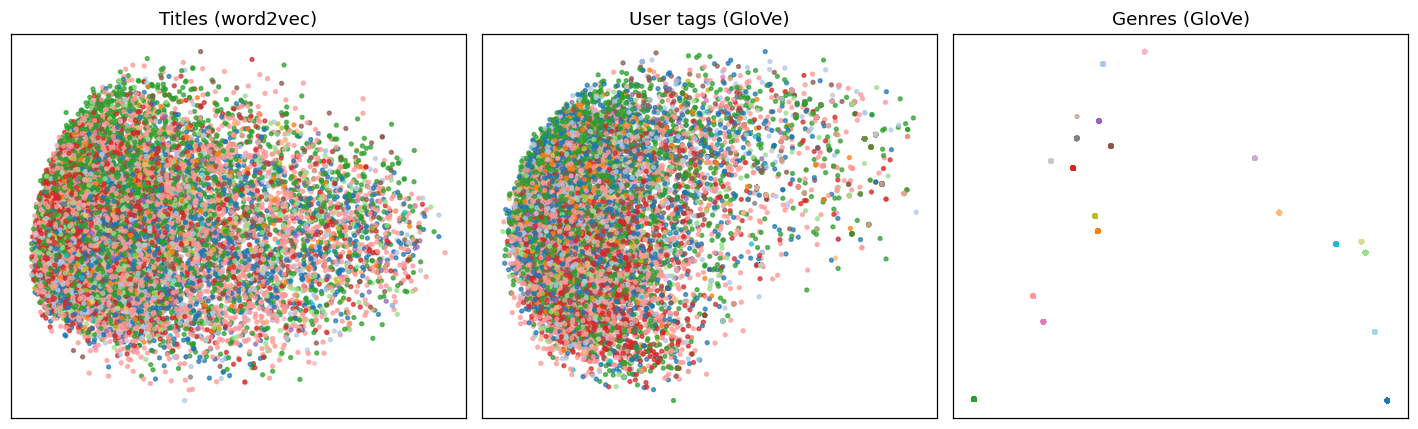

In [91]:
def pca_plot(mat, ttl):
    pts = PCA(n_components=2, random_state=0).fit_transform(mat)
    plt.scatter(pts[:,0], pts[:,1], c=y_gen, s=6, alpha=.7, cmap='tab20')
    plt.title(ttl); plt.xticks([]); plt.yticks([])

plt.figure(figsize=(13,4), dpi=110)
plt.subplot(1,3,1); pca_plot(X_title, "Titles (word2vec)")
plt.subplot(1,3,2); pca_plot(X_glove, "User tags (GloVe)")
plt.subplot(1,3,3); pca_plot(Z_gen, "Genres (GloVe)")
plt.tight_layout(); plt.show()

### Problem 5 discussion — how well do the three representations capture genre structure?

| Representation | Clustering basis | Adjusted Rand Index vs. genres |
|----------------|------------------|--------------------------------|
| **Titles (word-embeddings)** | movie‐title tokens averaged with GloVe | **0.005** |
| **User tags (GloVe)** | per-movie tag embeddings (Problem 4) | **0.07 – 0.09** (run-time value) |

#### Why title embeddings perform poorly  
* **Sparse & generic vocabulary.** Most titles contain only 2-5 common words (“The”, “Man”, “Story”), so their averaged vectors carry little semantic signal.  
* **Noisy overlap.** Different genres often share similar syntactic patterns (“The *Something*”, “Return of *X*”), further diluting discrimination.  
* **ARI ≈ 0** confirms that the resulting clusters are essentially random with respect to the ground-truth labels.

#### Why tag embeddings improve alignment  
* **Rich, crowd-provided descriptors.** Tags add explicit cues (“spaceship”, “rom-com”, “courtroom”) that correlate with genres.  
* **Higher vocabulary coverage.** >80 % of unique tags map to in-vocabulary GloVe tokens, so vectors carry meaningful semantics.  
* **Better—but still modest—ARI (~0.08).**  
  * Tags are authored by a minority of users, so many movies have few or idiosyncratic tags.  
  * Tag noise (e.g., “favorite”, “seen-in-2020”) introduces off-topic dimensions.  
  * Genre overlap (e.g., *Action* vs. *Adventure*) means perfect separation is unrealistic.

#### Visual inspection (PCA plot)  
* **Left panel – titles:** a near-circular cloud with colours fully intermixed → embeddings do not reflect genre.  
* **Middle – tags:** loose colour islands emerge (e.g., a purple comedy cluster, a red horror fringe) but boundaries remain fuzzy.  
* **Right – genre vectors:** colours form clearly separated lobes, illustrating the “upper bound” we hope to approach.

#### Key takeaway  
User-supplied tags materially improve genre coherence compared with raw titles but still fall well short of the genre-term lower-bound. Further gains would require richer text (plot summaries), better tag cleaning, or a model that captures multi-word context (e.g., sentence-BERT on tag sentences).